# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
entity_unit_map = {
    "width": {"centimetre", "foot", "millimetre", "metre", "inch", "yard"},
    "depth": {"centimetre", "foot", "millimetre", "metre", "inch", "yard"},
    "height": {"centimetre", "foot", "millimetre", "metre", "inch", "yard"},
    "item_weight": {"milligram", "kilogram", "microgram", "gram", "ounce", "ton", "pound"},
    "maximum_weight_recommendation": {"milligram", "kilogram", "microgram", "gram", "ounce", "ton", "pound"},
    "voltage": {"millivolt", "kilovolt", "volt"},
    "wattage": {"kilowatt", "watt"},
    "item_volume": {"cubic foot", "microlitre", "cup", "fluid ounce", "centilitre", "imperial gallon", "pint", "decilitre", "litre", "millilitre", "quart", "cubic inch", "gallon"}
}

all_units = set.union(*entity_unit_map.values())
all_units.add("unknown") 

# Data Inspection

In [4]:
train_data = pd.read_csv("../dataset/train.csv")
train_data.head()

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263859 entries, 0 to 263858
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_link    263859 non-null  object
 1   group_id      263859 non-null  int64 
 2   entity_name   263859 non-null  object
 3   entity_value  263859 non-null  object
dtypes: int64(1), object(3)
memory usage: 8.1+ MB


In [6]:
train_data.nunique()

image_link      255906
group_id           750
entity_name          8
entity_value     16405
dtype: int64

# Basic Preprocessing

In [7]:
def preprocess(df: pd.DataFrame, all_units):
    pattern = r'^\d+(\.\d+)?\s[a-zA-Z]+$'
    train_data_filtered = train_data[train_data['entity_value'].str.match(pattern)]

    unit_pattern = r'\s+([a-zA-Z]+)$'
    units = train_data_filtered['entity_value'].str.extract(unit_pattern)[0]

    train_data_filtered_2 = train_data_filtered[units.isin(all_units)]
    units = train_data_filtered_2['entity_value'].str.extract(unit_pattern)[0]

    valid_unique_units = set(units.dropna())

    return train_data_filtered_2, valid_unique_units

In [8]:
basic_df, valid_unique_units = preprocess(train_data, all_units=all_units)

In [9]:
basic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257652 entries, 0 to 263858
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_link    257652 non-null  object
 1   group_id      257652 non-null  int64 
 2   entity_name   257652 non-null  object
 3   entity_value  257652 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.8+ MB


In [10]:
valid_unique_units

{'centilitre',
 'centimetre',
 'cup',
 'decilitre',
 'foot',
 'gallon',
 'gram',
 'inch',
 'kilogram',
 'kilowatt',
 'litre',
 'metre',
 'microgram',
 'milligram',
 'millilitre',
 'millimetre',
 'ounce',
 'pint',
 'pound',
 'quart',
 'ton',
 'volt',
 'watt'}

# Deeper Pre-processing

In [34]:
def extract_numeric_and_unit(df: pd.DataFrame) -> pd.DataFrame:
    # Precompile the regex pattern for efficiency
    value_pattern = re.compile(r'^(\d+(\.\d+)?)\s([a-zA-Z]+)$')
    
    # Extract numeric values and units using vectorized operations
    df['numeric_value'] = df['entity_value'].str.extract(r'^(\d+(\.\d+)?)', expand=False)[0]
    df['unit'] = df['entity_value'].str.extract(r'\s+([a-zA-Z]+)$', expand=False)
    
    # Fill NaNs with empty strings
    df['numeric_value'].fillna('', inplace=True)
    df['unit'].fillna('', inplace=True)
    
    # Create a new DataFrame with index and extracted values
    extracted_df = df[['numeric_value', 'unit']]
    
    return extracted_df

# Extract numeric values and units
extracted_data = extract_numeric_and_unit(basic_df)

/var/folders/c8/j_nr7fhx4w9bxy7s92tnbphw0000gn/T/ipykernel_49153/3947244503.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['numeric_value'].fillna('', inplace=True)
/var/folders/c8/j_nr7fhx4w9bxy7s92tnbphw0000gn/T/ipykernel_49153/3947244503.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [35]:
extracted_data.head()

,numeric_value,unit
0,500.0,gram
1,1.0,cup
2,0.709,gram
3,0.709,gram
4,1400,milligram


/var/folders/c8/j_nr7fhx4w9bxy7s92tnbphw0000gn/T/ipykernel_49153/2388924644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['numeric_value'] = pd.to_numeric(df['numeric_value'], errors='coerce')


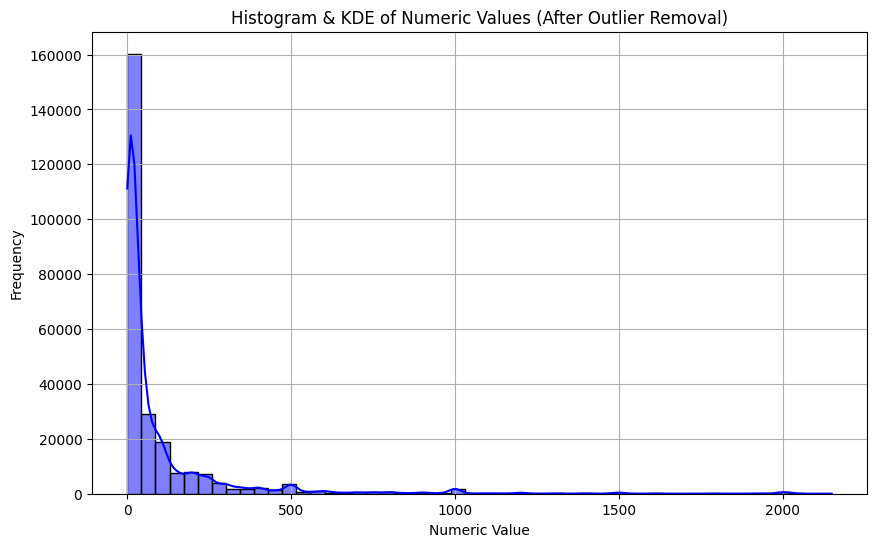

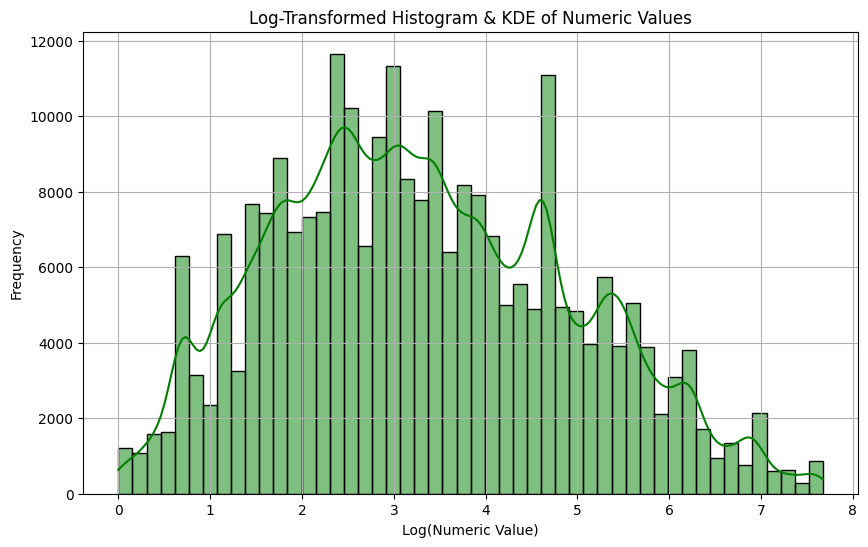

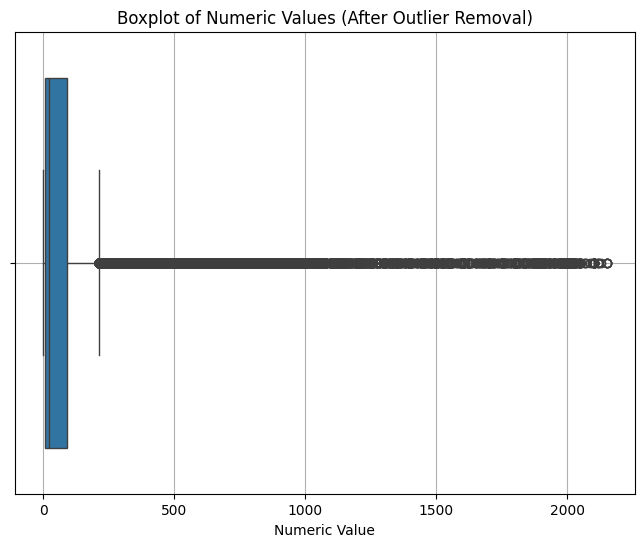

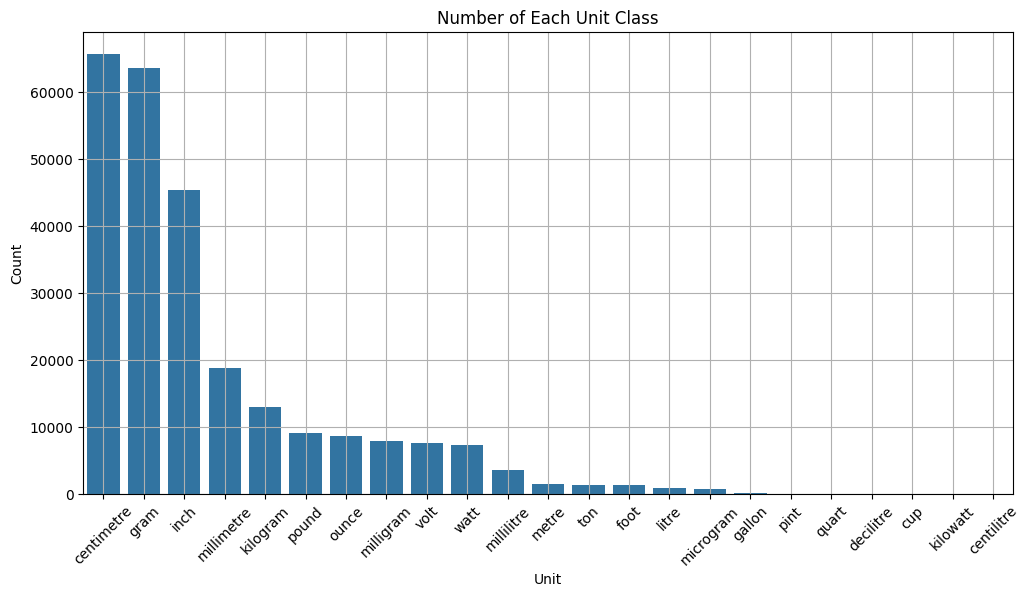

In [40]:
def visualize_extracted_data(df: pd.DataFrame):
    # Convert 'numeric_value' to float, ignoring errors for non-numeric values
    df['numeric_value'] = pd.to_numeric(df['numeric_value'], errors='coerce')
    
    # Drop NaNs (non-numeric rows) for numeric plots
    numeric_data = df.dropna(subset=['numeric_value'])
    
    # Remove outliers above the 99th percentile to get a more reasonable distribution
    upper_limit = numeric_data['numeric_value'].quantile(0.99)
    filtered_data = numeric_data[numeric_data['numeric_value'] <= upper_limit]
    
    # 1. Histogram & KDE Plot: Distribution of 'numeric_value' (after outlier removal)
    plt.figure(figsize=(10, 6))
    sns.histplot(filtered_data['numeric_value'], bins=50, kde=True, color='blue')
    plt.title('Histogram & KDE of Numeric Values (After Outlier Removal)')
    plt.xlabel('Numeric Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # 2. Histogram & KDE Plot with Log Scale: For wide-range distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(np.log1p(filtered_data['numeric_value']), bins=50, kde=True, color='green')
    plt.title('Log-Transformed Histogram & KDE of Numeric Values')
    plt.xlabel('Log(Numeric Value)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

    # 3. Boxplot: Distribution of 'numeric_value' (after outlier removal)
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=filtered_data['numeric_value'])
    plt.title('Boxplot of Numeric Values (After Outlier Removal)')
    plt.xlabel('Numeric Value')
    plt.grid(True)
    plt.show()

    # 4. Bar Plot: Distribution of units (unit classes)
    unit_counts = df['unit'].value_counts()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=unit_counts.index, y=unit_counts.values)
    plt.title('Number of Each Unit Class')
    plt.xlabel('Unit')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming extracted_data is already created from the previous steps
visualize_extracted_data(extracted_data)


In [39]:
extracted_data["numeric_value"].describe()

count    2.576520e+05
mean     5.234686e+10
std      1.779612e+13
min      0.000000e+00
25%      7.357500e+00
50%      2.400000e+01
75%      9.800000e+01
max      6.383737e+15
Name: numeric_value, dtype: float64

In [42]:
extracted_data.to_csv("../dataset/cleaned/numeric_unit.csv")

In [13]:
basic_df.to_csv("../dataset/cleaned/train_clean.csv")

In [12]:
basic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257652 entries, 0 to 263858
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   image_link    257652 non-null  object
 1   group_id      257652 non-null  int64 
 2   entity_name   257652 non-null  object
 3   entity_value  257652 non-null  object
dtypes: int64(1), object(3)
memory usage: 9.8+ MB


In [11]:
basic_df.head()

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram
